# 01-15 Simulation & Sampling

*Partially adapted from [Statisical Thinking for the 21st Century](https://statsthinking21.github.io/statsthinking21-core-site/index.html)*

Today we're going to discuss the "4 horsemen" of modern computational statistics:  
- Monte-carlo simulation
- Bootstrapping
- Permuting
- Cross-validation


Building strong intuitions about these concepts will enable you to make inferences and reason about **any** statistical analysis or model you do in the future!

*If you want to enjoy a funny youtube video (~40min) that partly inspired this notebook, I highly recommend watching [Statistics for Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA) by [Jake VanderPlas](http://vanderplas.com/).*   *Jake is one of my personal inspirations - a computational astrophysicist by training - but huge contributor and educator for the open-source scientific Python community.*

## Introduction

The use of **computer simulations** has become an essential aspect of modern statistics. For example, one of the most important books in practical computer science, called Numerical Recipes, says the following:

> *“Offered the choice between mastery of a five-foot shelf of analytical statistics books and middling ability at performing statistical Monte Carlo simulations, we would surely choose to have the latter skill.”*


In other words:


<div style="text-align:center">
<img src="./figs/jake.png" width="500px" alt="Figure 1">
<img src="./figs/jake2.png" width="500px" alt="Figure 1">
</div>

---

## Simulation: The Monte Carlo method

The concept of Monte Carlo simulation was devised by the mathematicians Stan Ulam and Nicholas Metropolis, who were working to develop an atomic weapon for the US as part of the Manhattan Project. They needed to compute the average distance that a neutron would travel in a substance before it collided with an atomic nucleus, but they could not compute this using standard mathematics. Ulam realized that these computations could be simulated using *random numbers*, just like a casino game. 

In a casino game such as a roulette wheel, numbers are generated at random; to estimate the probability of a specific outcome, one could play the game hundreds of times. Ulam’s uncle had gambled at the Monte Carlo casino in Monaco, which is apparently where the name came from for this new technique.

<img src="./figs/casino.jpg" width="500px" alt="Figure 1">

There are four steps to performing a Monte Carlo simulation:

1. Define a domain of possible values
2. Generate random numbers within that domain from a probability distribution
3. Perform a computation using the random numbers
4. Combine the results across many repetitions


### Example
As an example, let’s say that I want to figure out how much time to allow for an in-class quiz. We will pretend for the moment that we know that the distribution of quiz completion times is normal, with mean of 5 minutes and standard deviation of 1 minute. 

Given this, how long does the test period need to be so that we expect all students to finish the exam 99% of the time? 

There are two ways to solve this problem. The first is to calculate the answer using a mathematical theory known as the *statistics of extreme values*. However, this involves complicated mathematics. Alternatively, we could use Monte Carlo simulation. 

To do this, we need to **simulate** random samples from a normal distribution.

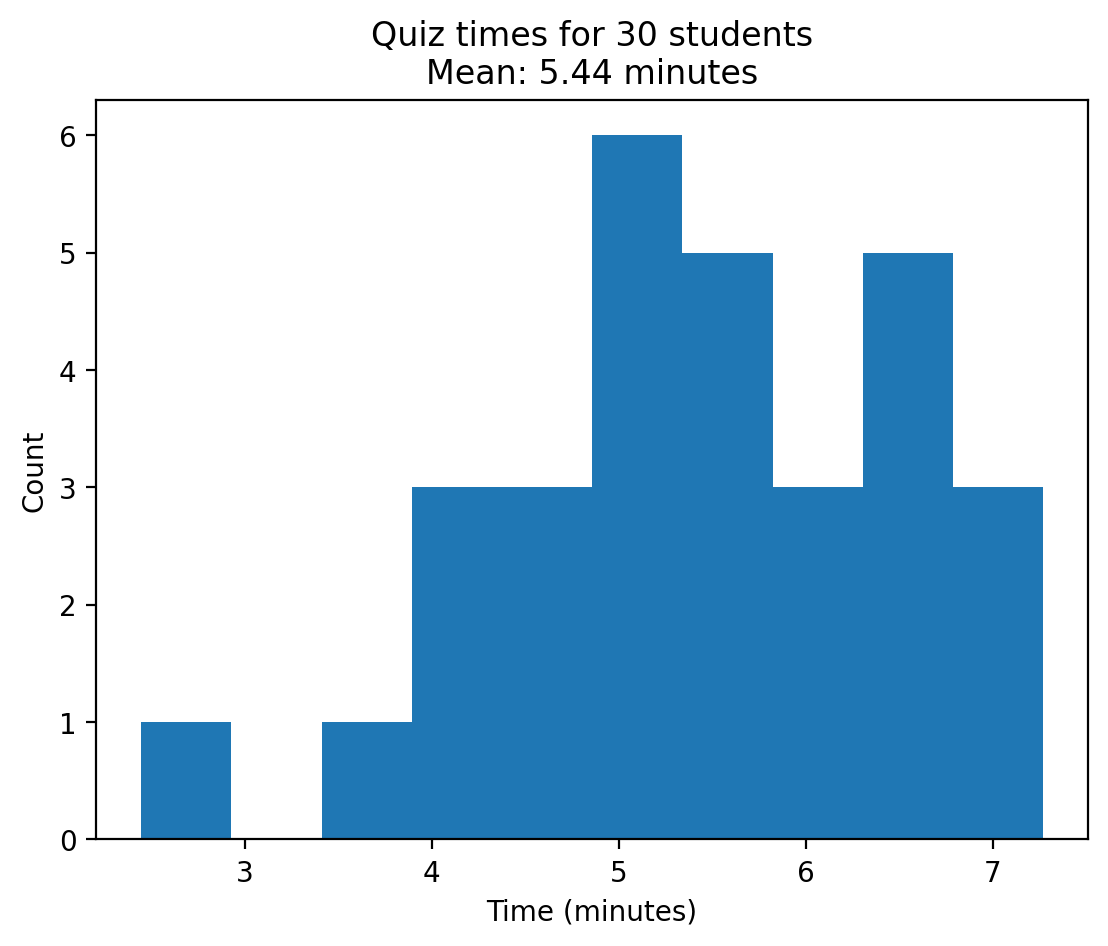

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0) # for reproducibility

num_students = 30

quiz_times = np.random.normal(loc=5, scale=1, size=num_students)

plt.hist(quiz_times);
plt.xlabel('Time (minutes)');
plt.ylabel('Count');
plt.title(f"Quiz times for {num_students} students\nMean: {np.mean(quiz_times):.2f} minutes");

Now, say that I administer 3 quizzes and record the finishing times for each student for each exam, which might look like the distributions presented here:

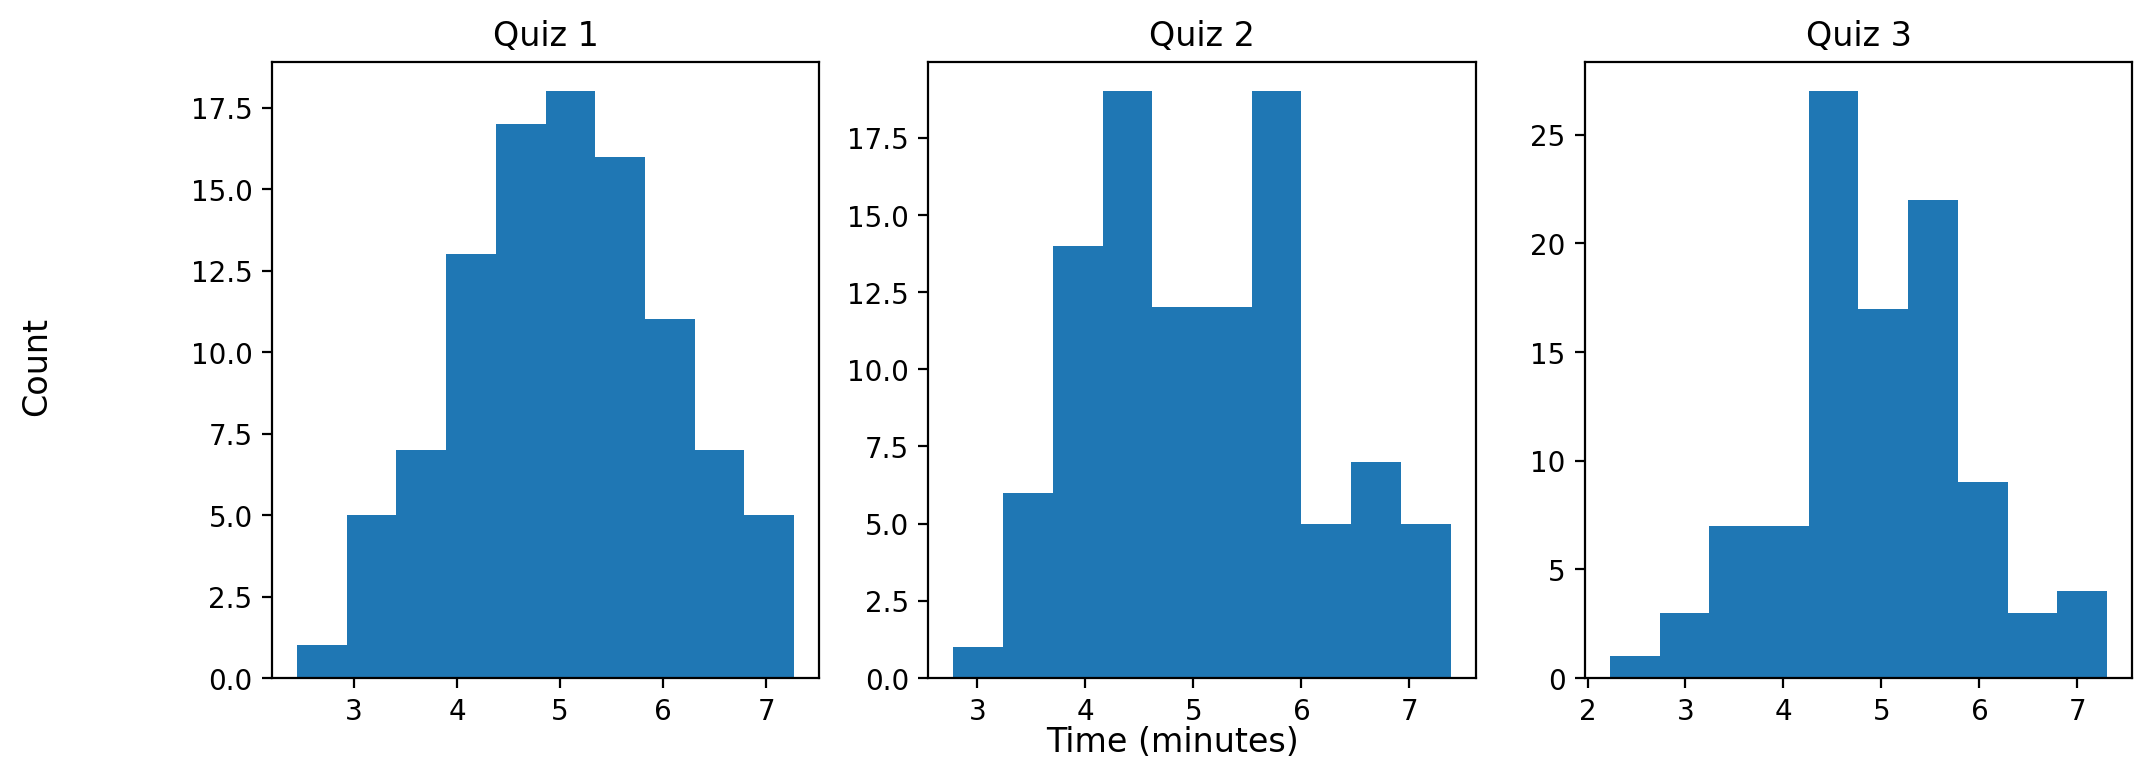

In [2]:
np.random.seed(0) # for reproducibility

fig, axs = plt.subplots(1,3, figsize=(12,4))

for idx, ax in enumerate(axs):
    finishing_times = np.random.normal(loc=5, scale=1, size=100)
    _ = ax.hist(finishing_times)
    _ = ax.set_title(f'Quiz {idx+1}')

fig.supxlabel('Time (minutes)');
fig.supylabel('Count');

Each simulated quiz of students assumes a normal distrubition. But what we really want to know to answer our question is not what the distribution of finishing times looks like, but rather what the distribution of the **longest finishing time for each quiz looks like**. 

To do this, we can:
1. Simulate the finishing times for a quiz, assuming a normal distribution
2. Record the *longest* finishing time for that quiz
3. Repeat a large number of times.
4. Plot the simulated distrubtion of longest finishing times, across the number of quizzes simullated


This will give us a **distrubution** of the maximimum quiz times, under the assumption that the finishing times of each quiz are normally distributed.

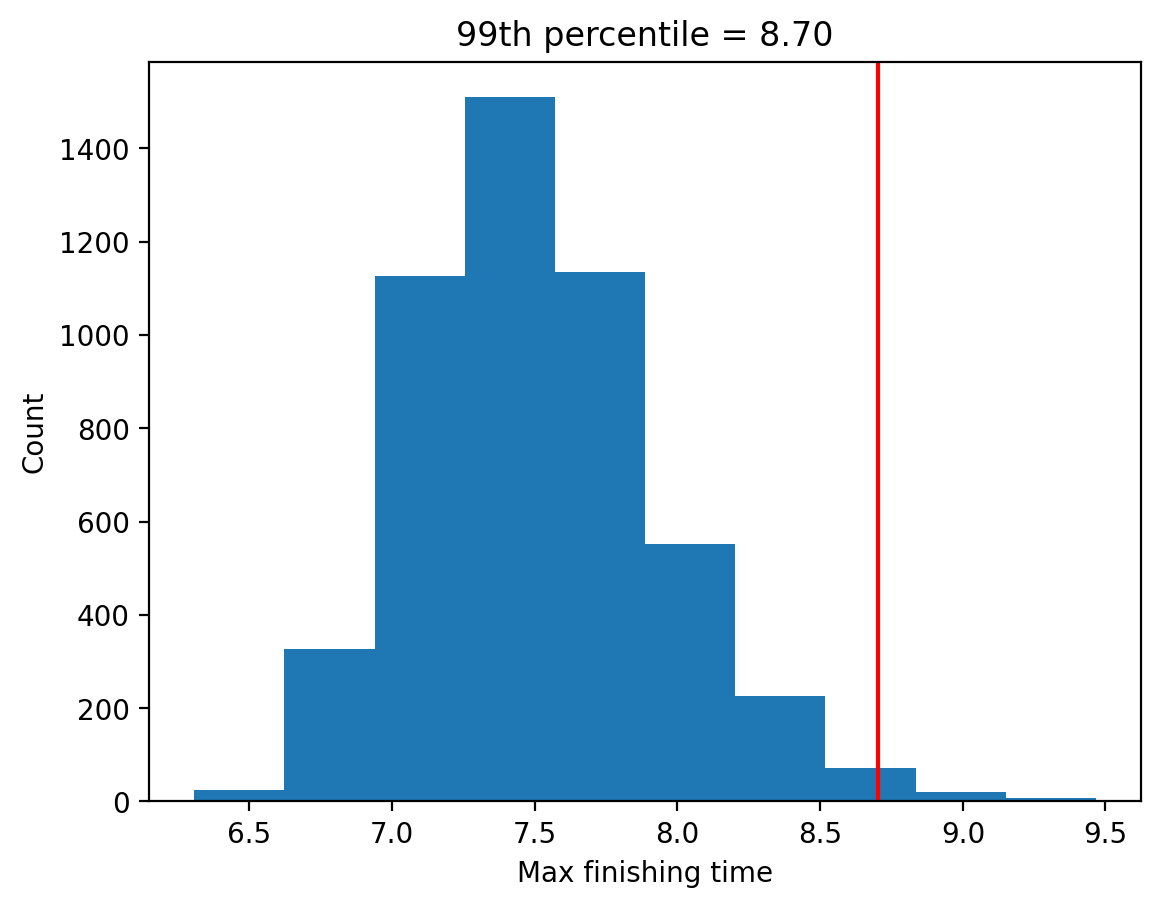

In [3]:
nsim = 5000
max_finishing_times = []
np.random.seed(0) # set seed for reproducibility

for sim in range(nsim):

    finishing_times = np.random.normal(loc=5, scale=1, size=100)
    max_finishing_times.append(finishing_times.max())

perc_99 = np.percentile(max_finishing_times, 99)

plt.hist(max_finishing_times);
plt.axvline(x=perc_99, color='red');
plt.xlabel('Max finishing time');
plt.ylabel('Count');
plt.title(f"99th percentile = {perc_99:.2f}");

This shows that the 99th percentile of the finishing time distribution falls at ~8.7, meaning that if we were to give that much time for the quiz, then everyone should finish 99% of the time. 


### Take-aways

When using simulation methods,  always important to remember that our **assumptions matter**. If they are wrong, then the results of the simulation are *useless*. 

In this case, we assumed that the finishing time distribution was *normally distributed* with a particular mean and standard deviation; if these assumptions are incorrect (and they almost certainly are, since it’s rare for elapsed times to be normally distributed), then the true answer could be very different!

Monte Carlo simulation methods show up in tons of domains of science and engineering, particularly when we're trying to reason about things with **uncertainty**. 

It allows us to move from the reasoning with logic and natural language in the abstract, to reasoning with numbers and figures in the concrete.

<img src="./figs/jake3.png" width="40%" alt="Figure 1">

---

## Bootstrap: Re-sampling *with* replacement

Above, we made assumptions about what type of distribution we expect the sampling distribution to look like *ahead of time* (normally distributed)

But what if we *can’t assume that the estimates are normally distributed*, or we *don’t know* their distribution? 

The idea of the bootstrap is to **use the data themselves to estimate an answer**. The name comes from the idea of pulling one’s self up by one’s own bootstraps, expressing the idea that we don’t have any external source of leverage so we have to rely upon the data themselves. The bootstrap method was conceived by Bradley Efron of the Stanford Department of Statistics, who is one of the world’s most influential statisticians.

The idea behind the bootstrap is that we repeatedly sample from the actual dataset; importantly, **we sample with replacement**, such that the same data point will often end up being represented multiple times within one of the samples. We then compute our statistic of interest on each of the bootstrap samples, and use the distribution of those estimates as our sampling distribution. 

In a sense, we treat our particular sample as the *entire population*, and then repeatedly sample with replacement to generate our boot-strapped samples for analysis. This makes the assumption that our particular sample is an accurate reflection of the population, which is probably reasonable for larger samples but can break down when samples are smaller.

<div style="text-align:center">
<img src="./figs/bootstrap.png" width="70%" alt="Figure 1">
</div>

Let's revisit our quiz-times example, and using boot-strapping to estimate the sampling distribution of the **maximum* quiz time**:

Imagine we collected data from a single class of 100 students who had an average quiz-completion time of 5min +/- 1min:

  Sample size ${n = 100}$  
  Mean  ${\mu = 5}$  
  Standard deviation ${\sigma = 1}$  

In [4]:
sample_mean = 5
sample_sd = 1
num_students = 100
np.random.seed(0)

finishing_times = np.random.normal(loc=sample_mean, scale=sample_sd, size=num_students)

print(
    f"Average finishing time: {finishing_times.mean():.2f} +/- {finishing_times.std():.2f}"
)

Average finishing time: 5.06 +/- 1.01


How much should we trust this sample mean estimate? How can we estimate our **sampling error**? 

We start by drawing a bootstrapped sample of size $n$ from the data:

In [5]:
# Notice replace = True
sample = np.random.choice(finishing_times, size=num_students, replace=True)

We compute the statistic of interest on this sample (max)

In [6]:
sample_max = sample.max()

4. We repeat steps 2-3 1000 times to build up the boot-strapped distribution of the max

In [7]:
boot_maxes = []
for i in range(10000):

    this_boot_max = np.random.choice(
        finishing_times, size=num_students, replace=True
    ).max()

    boot_maxes.append(this_boot_max)

# Convert it to numpy array to make it easier to work with
boot_maxes = np.array(boot_maxes)

We can calculate summary statistics over this **bootstrapped distribution** to get a sense of the variability across our estimates of the `max`:

In [8]:
# Calculate the mean and standard deviation
boot_mean, boot_sd = boot_maxes.mean(), boot_maxes.std()

Finally we can visualize the boostrapped distribution along with its mean and standard deviation:

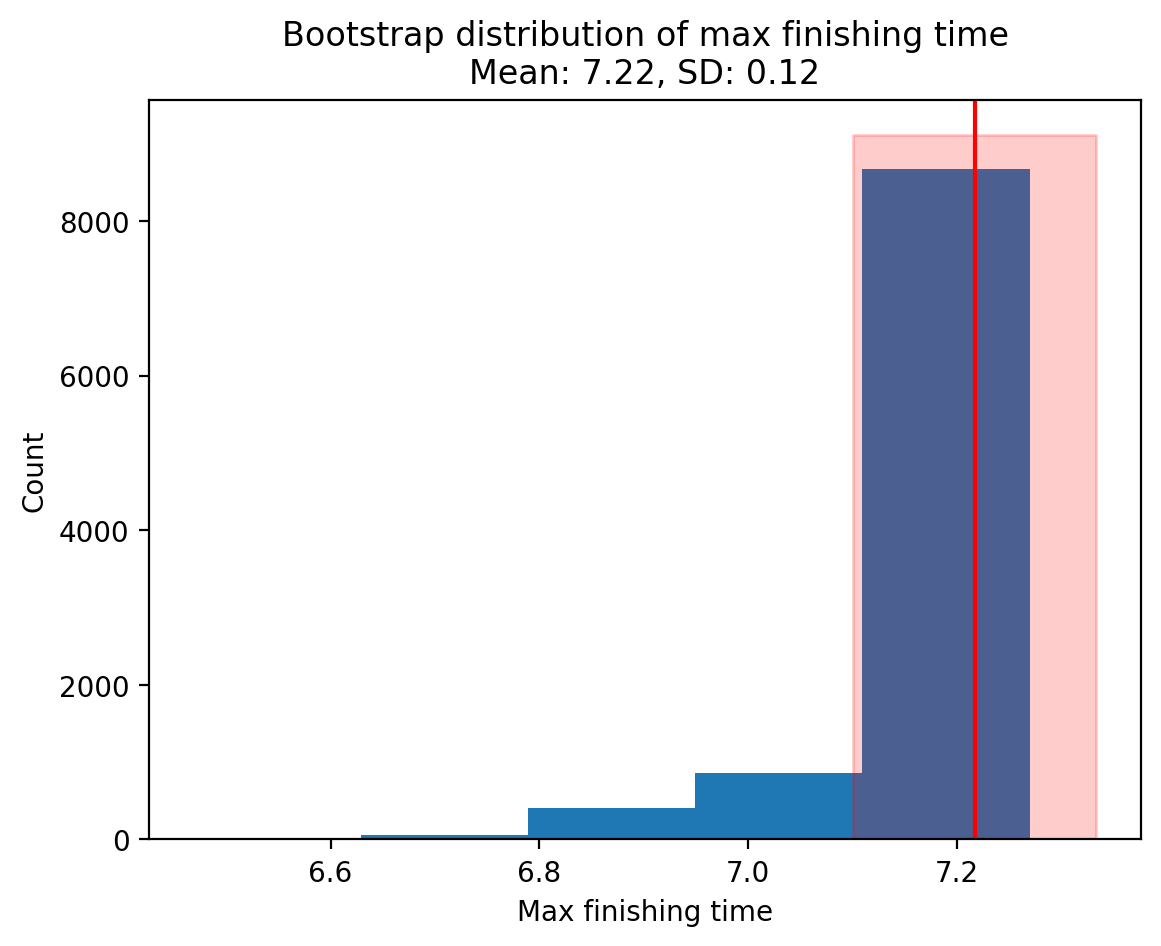

In [9]:
# Plot it
plt.hist(boot_maxes, bins=5)

# Add the mean
plt.axvline(boot_mean, color="red", label="Mean")

# Create error band for SD
x_min, x_max = boot_mean - boot_sd, boot_mean + boot_sd
y_min, y_max = plt.gca().get_ylim()  # Get the y-axis limits of the histogram

plt.fill_betweenx(
    [y_min, y_max], x_min, x_max, color="red", alpha=0.2, label="1 SD range"
)

plt.xlabel("Max finishing time")
plt.ylabel("Count")
plt.title(
    f"Bootstrap distribution of max finishing time\nMean: {boot_mean:.2f}, SD: {boot_sd:.2f}"
);

This distribution reflects the `max` quiz-time from **hypothetical samples** generated using the sample data we have at hand. It's distribution gives us a sense of how much variability we should expect for our `max` quiz-time, *were we to have collected another dataset of the same size*.

If our estimate bounces around a lot (wide bootstrapped distribution), we ought to *trust it less* because we can't be sure that the `max` estimate from our sample is representative of the `max` quiz time of the population! In this case we can always collect a larger sample size to try to get a *better estimate* of the statistic we want, i.e. the `max`.

On the other hand, even if our estimate doesn't bounce around a lot (narrow bootstrapped distribution), but it overlaps meaningfully with 0, we might consider that we can't *reliably* tell if our estimate is *actually* different than 0.


More formally:

**Standard Deviation** gives us this spread for a *single sample*.  
**Standard Error** gives us the spread across *hypothetical samples we didn't collect*

Standard Error = Standard Deviation of the *sampling distribution* (our bootstrapped distribution!)


<div style="text-align:center">
  <img src="./figs/fig8.png" width="60%" alt="Figure 1">
</div>

Standard Error implies that the quality of our measurements involve 2 factors

1. Population variability <- *we can't control this or easily know what it is ahead of time*
2. Size of any given sample <- *larger samples give us more **certainty** about what we're estimating*

At the same time it highlight how the *utility* of larger samples **diminishes** as sample size increases.  
Doubling a sample size, only increases the quality of our estimate by a factor of $\sqrt{2}$!

### Confidence Intervals 

We can further formalize the idea of *certainty* given some "threshold" we think is *meaningful* for our statistical question. 

For example, for some questions we might be ok with being *very* uncertain, as long as we feel like our estimate reflects what is likely to be true for *95% of such hypothetical samples*. For others, we may want a more precise value, at the expense of capturing only *80% of such hypothetical samples*.

Formally, we refer to these as **confidence intervals** for our estimates. This is a range of values that we expect to contain the true value of the statistic we want to estimate X% of the time. And bn X% of the time we *specifcally* mean, in X% of hypothetical samples with their *own uncertainty*. 

For example, if we have a 95% confidence interval of [2.5, 4.5] for the `max` quiz-time, we expect that 95% of our bootstrapped samples will contain the *true* value of the `max` quiz-time within their confidence intervals.

Concretely, if we bootstrapped 20 samples and calculated their confidence intervals, we expect that 19 of the 20 samples will contain the true value of the `max` quiz-time *within their own confidence intervals*.

<div style="text-align:center">
<img src="./figs/ci_dance.png" width="500px" alt="Figure 1">
</div>

*Note If you want to see this more interactively, we recommend checking out [The Dance of the p-values](https://www.youtube.com/watch?v=5OL1RqHrZQ8) by Geoff Cumming*

We manually calculate our 95% confidence intervals in a pretty simple way: just by percentile thresholding

In [10]:
np.percentile(boot_maxes, [2.5, 97.5])

array([6.89588918, 7.26975462])

But this makes some strong assumptions about the *shape* of the bootstrapped distrubtion - namely that it's **symmetric** and **normal-shaped**.  
In practice, we want to use more advanced methods that account for the *bias* and *skew* of the bootstrapped distribution without assuming any shape. 

Most commonly, we use **BCa** (bias-corrected and accelerated) CIs, which specifically account for this. Fortunately for us, we don't need to keep writing `for` loops and calculate this manually.

We're going to use the awesome [`scipy` library](https://docs.scipy.org/doc/scipy-1.15.0/tutorial/index.html#user-guide) and its `bootstrap` function to do this for us, this time calculating the **median** quiz time:

In [11]:
# Import it
from scipy.stats import bootstrap

np.random.seed(0)  # for reproducibility

# bootstrap() expects a *sequence* or arrays as input
# since only have one array, we can turn it into a sequence
# by wrapping it in a tuple

data = (finishing_times,)  # wrap it in a tuple

result = bootstrap(
    data, statistic=np.median, n_resamples=1000, confidence_level=0.95, method="BCa"
)

result?

Type:        BootstrapResult
String form: BootstrapResult(confidence_interval=ConfidenceInterval(low=4.816445657080908, high=5.327840624247 <...> 5.15494743, 5.13651324, 5.06651722, 5.09153872, 5.09671466]), standard_error=0.11268765299144144)
File:        ~/miniconda3/envs/201b/lib/python3.11/site-packages/scipy/stats/_resampling.py
Docstring:  
Result object returned by `scipy.stats.bootstrap`.

Attributes
----------
confidence_interval : ConfidenceInterval
    The bootstrap confidence interval as an instance of
    `collections.namedtuple` with attributes `low` and `high`.
bootstrap_distribution : ndarray
    The bootstrap distribution, that is, the value of `statistic` for
    each resample. The last dimension corresponds with the resamples
    (e.g. ``res.bootstrap_distribution.shape[-1] == n_resamples``).
standard_error : float or ndarray
    The bootstrap standard error, that is, the sample standard
    deviation of the bootstrap distribution.

The output of `bootstrap` is a special `scipy` object called a `BootstrapResult`. It doesn't *really* matter that we haven't seen this type of object before, because we can still access it's attributes using `.` notation. 

For example, we can plot the bootstrapped distribution easily:

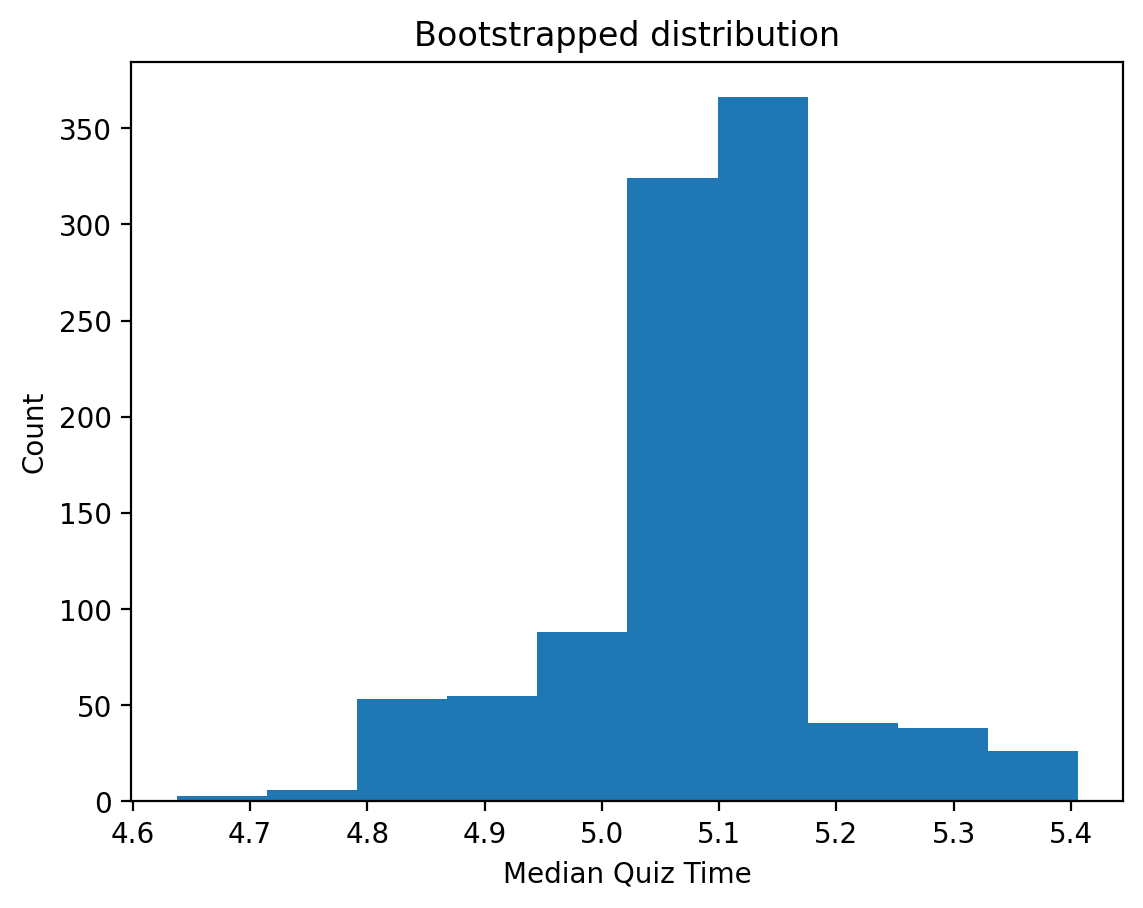

In [12]:
plt.hist(result.bootstrap_distribution);
plt.title('Bootstrapped distribution');
plt.xlabel('Median Quiz Time');
plt.ylabel('Count');

`bootstrap` also already computes confidence intervals for us:

In [13]:
result.confidence_interval

ConfidenceInterval(low=4.816445657080908, high=5.327840624247037)

Let's visualize the bootstrap distribution and overlay the confidence intervals:

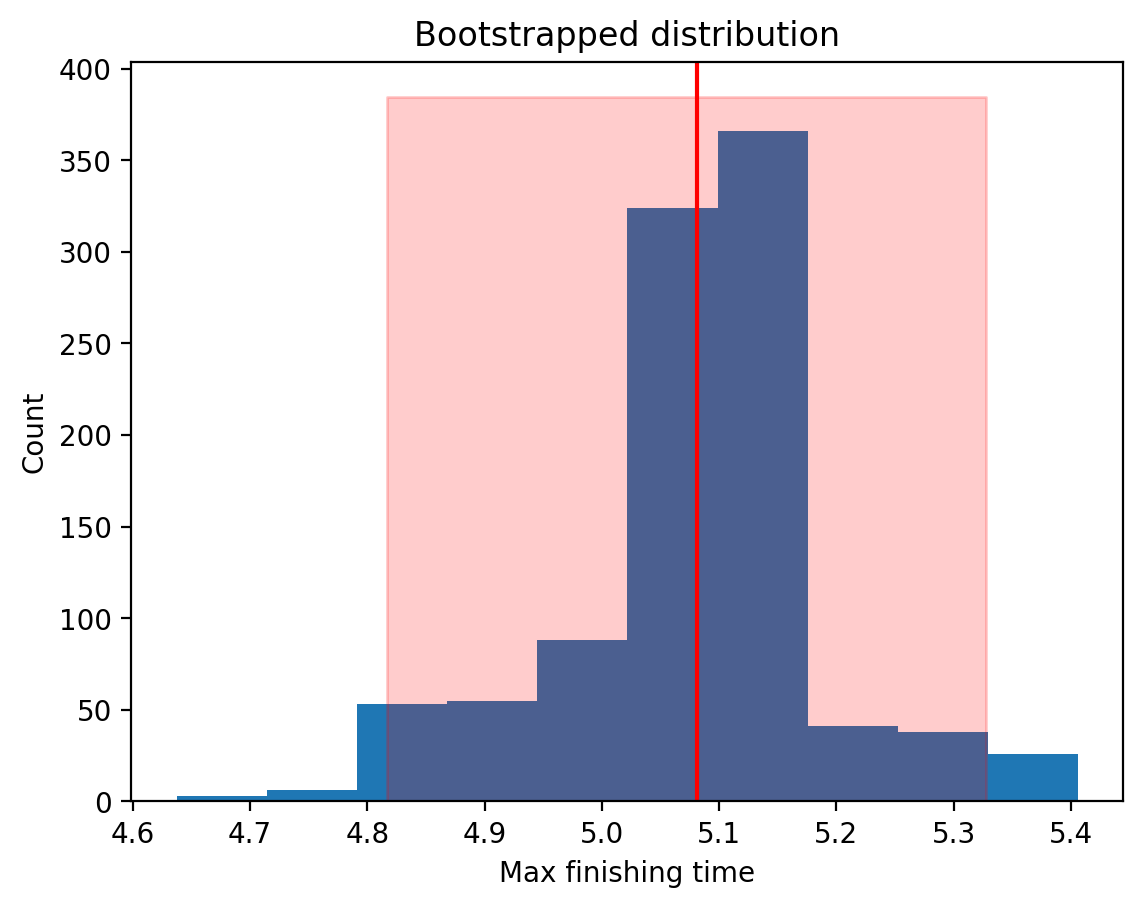

In [14]:
# Calculate the mean
scipy_boot_mean = result.bootstrap_distribution.mean()

# Plot it
plt.hist(result.bootstrap_distribution)

# Add the mean
plt.axvline(scipy_boot_mean, color="red", label="Mean")

# Create error band for CIs
x_min, x_max = result.confidence_interval

y_min, y_max = plt.gca().get_ylim()  # Get the y-axis limits of the histogram

plt.fill_betweenx(
    [y_min, y_max], x_min, x_max, color="red", alpha=0.2, label="1 SD range"
)

plt.xlabel("Max finishing time")
plt.ylabel("Count")
plt.title("Bootstrapped distribution");

### Checking out the sampling

And we can also verify that the **Standard Error** it calculated is equal to the **Standard Deviation** of the bootstrapped distribution:

In [15]:
result.standard_error == result.bootstrap_distribution.std(ddof=1)

True

Notice the `ddof = 1` above. This allow us to control the correction factor for our *degrees of freedom* in the calculation of the standard deviation. The default value is `ddof=0`, which means that the standard deviation is calculated with no correction, assuming we're measuring the *whole population*. 

When we set `ddof=1`, the standard deviation is corrected for the fact that we're using *another estimate* (the sample mean) or "consuming a degree of freedom" in order to calculate the standard deviation. 


#### Intuition for degrees-of-freedom

Intuitively we can think about degrees-of-freedom (dof) as representing the number of values in a calculation *that are free to vary* while still satisfying any constraints imposed on the data. More generally in statistics, we keep track of this number to adjust calculations and account for the fact that we're often using estimates of parameters to estimate *other parameters*.

In this case, we're using the *sample mean* to calculate our *sample standard deviation*. If our estimate of the *mean* changes, so does our estimate of the *standard deviation*. In other words, our esimate of the *mean* is **constraining** how free-ly our estimate of the *standard deviation* can bounce around! 

This way of thinking about dof as the "freedom of movement" will make more sense when we get into models and model parameters. You should get the sense that it's reflecting a notion of "independence" among the quantities we're estimating.


---

## Permutation: Re-sampling *without* replacement

In addition to the uncertainty of our estimate, we are also often interested in the *probability of observing this estimate under random conditions*. 

**Permutation** also referred to as *randomization* or *shuffling* allows us to resample our data in a way that gives us an answer to this question!

It's a bit more intuitive to consider this when we're comparing 2 estimates, so let's extend our quiz example to a second classroom that *doesn't allow student to bring their laptops to class*.

We're interested in whether having/not-having your laptop affects the quiz-times of each classroom, in other words, the **difference in means** between the two classes:

<div style="text-align:center">
  <img src="./figs/shuffle.png" width="60%" alt="Figure 1">
</div>



In [16]:
class_1_mean = 5
class_2_mean = 5.5
num_students_per_class = 100
np.random.seed(0)

class_1 = np.random.normal(loc=class_1_mean, size=num_students)
class_2 = np.random.normal(loc=class_2_mean, size=num_students)
observed_difference = class_2.mean() - class_1.mean()

print(f"Observed difference (minutes): {observed_difference:.2f}")

Observed difference (minutes): 0.52


How would we approach this with permutation? In general we want to randomize the **exchangeable** observations in our data. Because each student is only in one class, we can **shuffle** the class labels for each student and then re-compute the quiz time for each *shuffled* class:

In [17]:
both_classes = np.concatenate((class_1, class_2))
shuffled_classes = np.random.permutation(both_classes)

class_1_shuffled = shuffled_classes[: len(class_1)]
class_2_shuffled = shuffled_classes[len(class_1) :]

shuffled_diff = class_2_shuffled.mean() - class_1_shuffled.mean()

print(f"Shuffled difference (minutes): {shuffled_diff:.2f}")


Shuffled difference (minutes): 0.04


That looks much smaller that the observed difference, but what if we shuffled differently?

In [18]:
shuffled_classes = np.random.permutation(both_classes)

class_1_shuffled = shuffled_classes[: len(class_1)]
class_2_shuffled = shuffled_classes[len(class_1) :]

shuffled_diff = class_2_shuffled.mean() - class_1_shuffled.mean()

print(f"Shuffled difference (minutes): {shuffled_diff:.2f}")

Shuffled difference (minutes): 0.32


Similar to bootstrapping, we can repeat this process many times, to build up a distribution of *shuffled mean differences*:

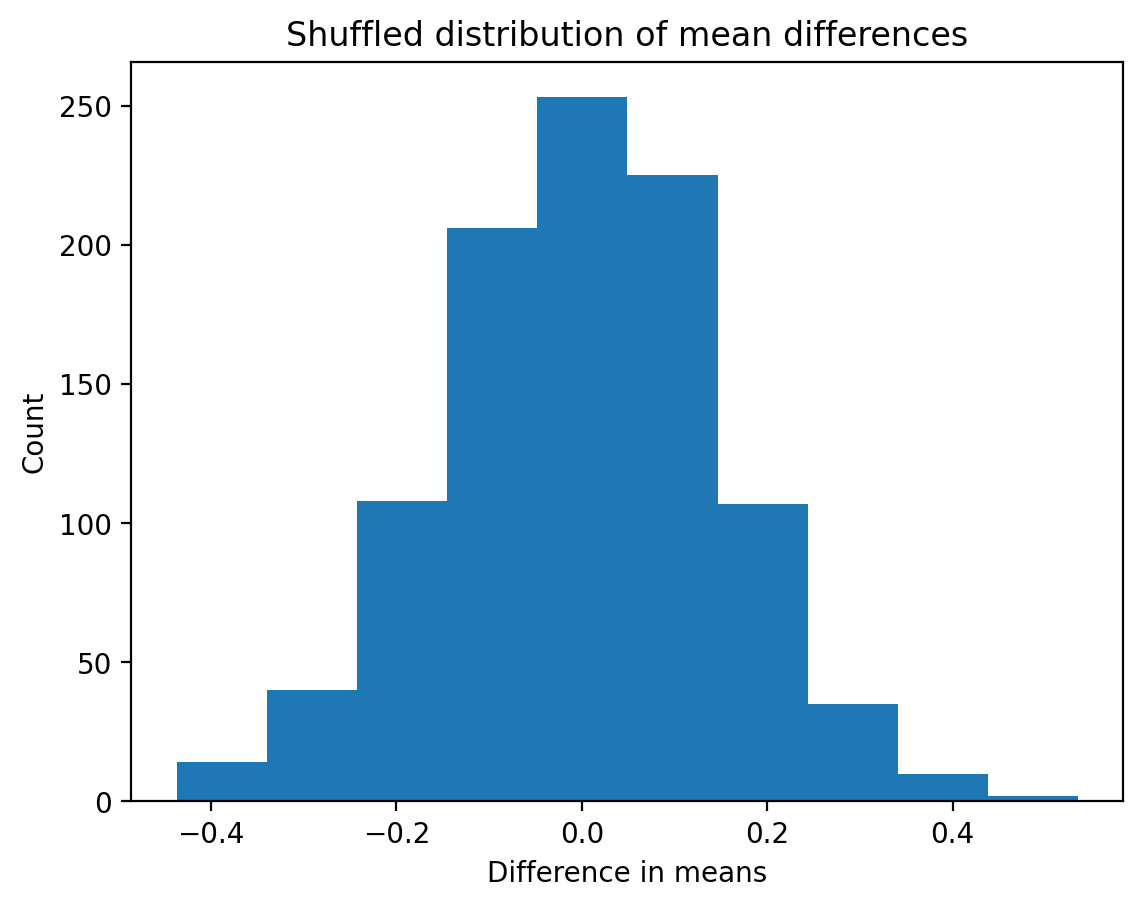

In [19]:
permuted_diffs = []
for _ in range(1000):

    # Shuffle the combined data

    shuffled_classes = np.random.permutation(both_classes)

    # Split into two groups
    class_1_shuffled = shuffled_classes[: len(class_1)]
    class_2_shuffled = shuffled_classes[len(class_1) :]

    # Calculate the difference in means for this permutation
    shuffled_diff = class_2_shuffled.mean() - class_1_shuffled.mean()

    # Store it
    permuted_diffs.append(shuffled_diff)

permuted_diffs = np.array(permuted_diffs)

plt.hist(permuted_diffs);
plt.xlabel("Difference in means");
plt.ylabel("Count");
plt.title("Shuffled distribution of mean differences");

If you've ever wondered what a **null distribution** is, you're looking at one! Permutation allows us to **create a null distribution** for any statistic.

This distribution reflects the values we think the statistic could have **in a hypothetical random world**, where random is specifically tied to the factor we think matters for that statistic: in this case *which class a student was in*.

We can return to our original question by asking: *how often do we see our **observed estimate** in this randomized distribution?*

In [20]:
permuted_p = np.mean(permuted_diffs >= observed_difference)

And then visualize our observed statistic against this distribution:

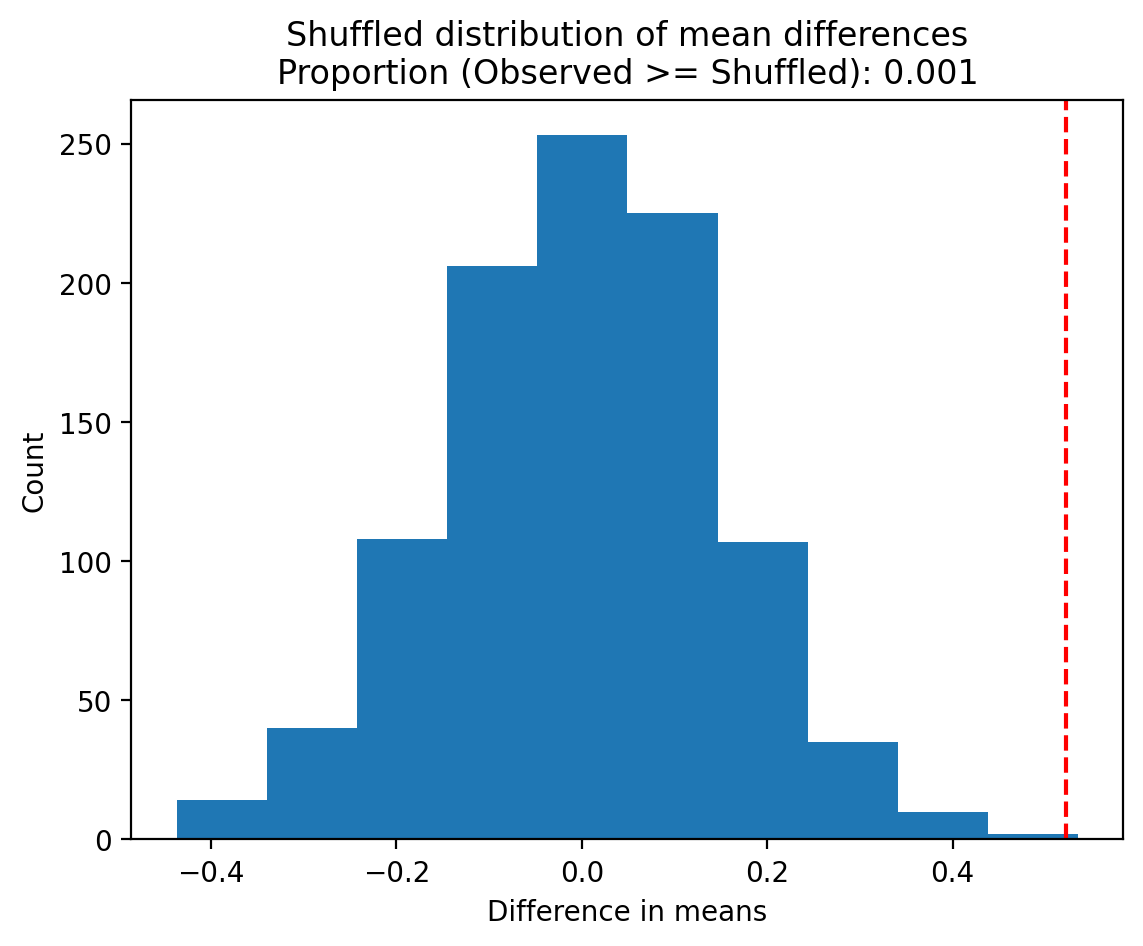

In [21]:
plt.hist(permuted_diffs);
plt.axvline(observed_difference, color="red", linestyle="--");
plt.xlabel("Difference in means");
plt.ylabel("Count");
plt.title(f"Shuffled distribution of mean differences\nProportion (Observed >= Shuffled): {permuted_p}");

---

## Cross-validation

Our final resampling method takes up back to the **Two Cultures** of statistical modeling: *explanation* and *prediction*. 

We've seen how bootstraping can give us a sense of *uncertainty* about our estimate (sample mean of a class). 

But another notion of uncertainty we can think about is *how good is the mean at **predicting an unobserved student's** quiz time*?

Remember from last week - that the *mean* as an estimator minimizes the **SSE** (sum of squared errors). 

We can convert this value to our *average error* on the original scale of the data by taking the square-root of the average error (RMSE: root mean squared error):

In [ ]:
RMSE = np.sqrt(np.mean((finishing_times - finishing_times.mean()) ** 2))

print(f"Root Mean Squared Error: {RMSE:.6f} minutes")

This tells us that by using the *mean* as a proxy for any single observation (single student's quiz time), we're **wrong** by approximately 1 minute relative to their true quiz time.

But what we really want to know is how wrong we are **students we did not observe**! In other words, how well does our observed mean **generalize** to the population of all students?

We simulate this via **cross-validation** or *out-of-sample* testing. We'll do this by splitting our observations into **random splits or folds** - one to *estimate* the mean, and one to *evaluate* how well the mean generalizes to new students - and then repeat this process with more random splits:

<div style="text-align:center">
  <img src="./figs/crossval.png" width="60%" alt="Figure 1">
</div>

In [22]:
np.random.seed(0)  # For reproducibility

# Number of splits/folds for cross-validation
k = 5
n = len(finishing_times)

# Generate indices for k folds
indices = np.arange(n)

# Randomize them so each fold has a different split of students
np.random.shuffle(indices)

# Split indices into k approximately equal-sized folds
folds = np.array_split(indices, k)

# Cross-validation for RMSE
rmse_values = []

for i in range(k):

    # Use one fold to estimate mean
    # and the other to test how well it generalizes
    test_indices = folds[i]
    train_indices = np.setdiff1d(indices, test_indices)

    observed_students = finishing_times[train_indices]
    unobserved_students = finishing_times[test_indices]

    # Step 2: Estimate mean using observed students
    train_mean = np.mean(observed_students)

    # Step 3: Calculate RMSE on unobserved students
    rmse = np.sqrt(np.mean((unobserved_students - train_mean) ** 2))
    rmse_values.append(rmse)

print(f"RMSE per fold: {rmse_values}")

RMSE per fold: [0.9861208571652235, 1.0251420562350702, 1.0531110065581861, 1.1192749932421364, 0.8538980372557612]


Then we can summarize our *out-of-sample* RMSE across out folds:

In [23]:
# Average RMSE across folds
avg_rmse = np.mean(rmse_values)
print(f"Cross-validated RMSE: {avg_rmse:.6f}")

Cross-validated RMSE: 1.007509


In this case the RMSE for *unobserved students* is slightly worse than the observed students. This is what we expect since the unobserved students, were not used to estimate the sample mean. 

At the same time, they're not *that* different, because we generated our classroom assuming all students come from the same population with the same mean!

We'll be revisiting cross-validation more later in the course, and in practice we have many tools to make this easier for us and split the data up in more interesting ways. We'll leave it as an exercise to you to explore the [scikit-learn library](https://scikit-learn.org/stable/modules/cross_validation.html) which has many handy functions to perform cross-validation, such as:

- `train_test_split`: Splits data into training and testing sets
- `kfold`: Splits data into k-folds for cross-validation
- `stratified_kfold`: Splits data into k-folds for cross-validation with stratified sampling

---

# Challenge

Your turn to try these methods out with the following challenge!

Imagine you're conducting research at a wildlife preserve to study the feeding behavior of a rare species of *red pandas*. 

<div style="text-align: center;">
<img src="./figs/pandas.jpeg" width="30%" alt="Figure 1">
</div>


Since this is a new species, the preserve wants to know how much the animals are eating in order to ensure both their health and enough supplies.  
You’ve been given data on the amount of food (in kg) consumed per day by individual foxes (100 total) during a one-week observation period in a file called `pandas_food.npy`.

Use these data to complete the following tasks:

In [25]:
import numpy as np

np.random.seed(0)  # For reproducibility
n_foxes = 100
true_mean = 6
true_sd = 2  # Increase spread to make assumptions differ more
outliers = [20, 22]  # Add a couple of extreme values

# Simulate data with outliers
arr = np.concatenate([np.random.normal(true_mean, true_sd, n_foxes), outliers])
# arr = np.random.normal(loc=6.3, scale=1.2, size=200)
np.save('panda_food.npy', arr)

In [7]:
np.random.seed(0)  # For reproducibility
n_leopard = 102
true_mean = 7
true_sd = 4  # Increase spread to make assumptions differ more

# Simulate data with outliers
arr = np.random.normal(true_mean, true_sd, n_foxes)
# arr = np.random.normal(loc=6.3, scale=1.2, size=200)
np.save('leopard_food.npy', arr)

## Simulation

Use Monte Carlo simulation to simulate and compare the sampling distribution of pandas' **mean** food consumption under 2 different assumptions:

1. That *mean* food consumption is **normally distributed**
2. That *mean* food consumption is **uniformally distributed**


Which of these assumptions is more likely to be true? Why?

In [ ]:
# Your code here
panda_food = np.load('panda_food.npy')

### Solution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

pandas_food = np.load('pandas_food.npy')

plt.hist(pandas_food);

In [ ]:
norm_means = [
    np.mean(np.random.normal(loc=pandas_food.mean(), size=pandas_food.size))
    for _ in range(1000)
]
plt.hist(norm_means);

In [ ]:
uniform_means = [
    np.mean(np.random.uniform(pandas_food.min(), pandas_food.max(), size=pandas_food.size))
    for _ in range(1000)
]
plt.hist(uniform_means);

## Bootstrap

Use bootstrapping (re-sampling *with* replacement) to estimate the sampling distribution of *min*, *max*, *mean*, and *median* of the data.  
For each estimate, provide the 95% confidence intervals for the boostrapped estimate.  

Can you interpret each statistic and CI so the animal preserve staff can understand how to think about them?

*Hint: check out the `bootstrap` function in `scipy.stats`*

In [ ]:
# Your code here

### Solution

In [68]:
# Your code here
from scipy.stats import bootstrap

data = (pandas_food,)

b_mean = bootstrap(data, statistic=np.mean, n_resamples=1000)
b_median = bootstrap(data, statistic=np.mean, n_resamples=1000)
b_min = bootstrap(data, statistic=np.min, n_resamples=1000)
b_max = bootstrap(data, statistic=np.max, n_resamples=1000)

In [ ]:
b_mean.confidence_interval
b_median.confidence_interval
b_min.confidence_interval
b_max.confidence_interval

## Permutation

The preserve is also really concerned with how much natural predators of red pandas, **snow leopards** are eating, especially if they're eating **more** than the pandas.  
They've been similarily tracking their food intake over the same week in a file called `leopard_food.npy`. Using this file along with the `pandas_food.npy` file, run a permutation to compare the **mean difference** in food intake between pandas and leopards.

Can you explain what you found to the animal preserve staff to help answer their question?

In [ ]:
# Your code here
leopard_food = np.load('leopard_food.npy')

## Cross-validation

One of the longest-employed members of the staff has observed that there might be a lot of variability in food consumption across members of each species (i.e. across pandas or across leopards). Having taken a statistics course many years ago, they're wondering if the `mean` is a good estimate of food intake for each species or the `median` might be more useful.

Using cross-validation, can you compare the `mean` and `median` as estimators of food intake for each species?  
Feel free to use any type of data-splitting scheme you like (e.g. k-fold, randomized, etc.)

*Hint: You can evaluate the mean by calculating the RMSE (root mean squared error) and the median by calculated the MAE (mean absolute error).*

In [ ]:
# Your code here